In [2]:
!pip install prophet scikit-learn optuna matplotlib pandas numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [3]:
# Generate Synthetic Time Series Dataset
np.random.seed(42)

dates = pd.date_range(start="2018-01-01", end="2023-12-31", freq="D")
n = len(dates)

trend = np.linspace(50, 200, n)

weekly = 10 * np.sin(2 * np.pi * dates.dayofweek / 7)
yearly = 20 * np.sin(2 * np.pi * dates.dayofyear / 365)

marketing_spend = np.random.normal(100, 20, n)
macro_index = np.random.normal(50, 10, n)

noise = np.random.normal(0, 5, n)

y = trend + weekly + yearly + 0.3 * marketing_spend + 0.5 * macro_index + noise

df = pd.DataFrame({
    "ds": dates,
    "y": y,
    "marketing_spend": marketing_spend,
    "macro_index": macro_index
})

df.head()

,ds,y,marketing_spend,macro_index
0,2018-01-01,107.301172,109.934283,54.621727
1,2018-01-02,123.856786,97.234714,70.243096
2,2018-01-03,109.951559,112.953771,36.368260
3,2018-01-04,118.985265,130.460597,51.897062
4,2018-01-05,94.508204,95.316933,43.380178


In [10]:
# Train-Test Split
train = df.iloc[:-365]
test = df.iloc[-365:]

In [12]:
# Baseline Prophet Model
baseline_model = Prophet()
baseline_model.fit(train)

future_baseline = baseline_model.make_future_dataframe(periods=365)
baseline_forecast = baseline_model.predict(future_baseline)

baseline_pred = baseline_forecast.iloc[-365:]["yhat"]

baseline_mae = mean_absolute_error(test["y"], baseline_pred)
baseline_mse = mean_squared_error(test["y"], baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Baseline MAE: 7.38096486871548
Baseline RMSE: 9.422778581687915


In [13]:
# Prophet with External Regressors
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05
)

model.add_regressor("marketing_spend")
model.add_regressor("macro_index")

model.fit(train)

future = test[["ds", "marketing_spend", "macro_index"]]
forecast = model.predict(future)

forecast[["ds", "yhat"]].head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2023-01-01,219.723260
1,2023-01-02,236.321705
2,2023-01-03,238.015741
3,2023-01-04,253.054154
4,2023-01-05,233.039196


In [14]:
# Hyperparameter Optimization (Optuna)
def objective(trial):
    cps = trial.suggest_float("changepoint_prior_scale", 0.01, 0.5)
    sps = trial.suggest_float("seasonality_prior_scale", 1.0, 20.0)

    model = Prophet(
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        yearly_seasonality=True,
        weekly_seasonality=True
    )

    model.add_regressor("marketing_spend")
    model.add_regressor("macro_index")

    model.fit(train)

    future = test[["ds", "marketing_spend", "macro_index"]]
    forecast = model.predict(future)

    mae = mean_absolute_error(test["y"], forecast["yhat"])
    return mae


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

study.best_params

[I 2026-02-06 07:21:24,234] A new study created in memory with name: no-name-f1bc3b10-bc46-4e0f-811b-b32b07625de8
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2026-02-06 07:21:24,697] Trial 0 finished with value: 4.13741300309339 and parameters: {'changepoint_prior_scale': 0.1020606611695372, 'seasonality_prior_scale': 5.312546825836493}. Best is trial 0 with value: 4.13741300309339.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2026-02-06 07:21:25,290] Trial 1 finished with value: 4.16611296941098 and parameters: {'changepoint_prior_scale': 0.22669612674104778, 'seasonality_prior_scale': 13.469360665765509}. Best is trial 0 with value: 4.13741300309339.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2026-02-06 07:21:25,723] Trial 2 finished with value: 4.100813787783425 and parameters: {'changepoint_prior_scale': 0.0

{'changepoint_prior_scale': 0.011517513040042532,
 'seasonality_prior_scale': 1.504304410273642}

In [16]:
# Train Optimized Prophet Model
best_params = study.best_params

opt_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    yearly_seasonality=True,
    weekly_seasonality=True
)

opt_model.add_regressor("marketing_spend")
opt_model.add_regressor("macro_index")

opt_model.fit(train)

opt_forecast = opt_model.predict(test)

opt_mae = mean_absolute_error(test["y"], opt_forecast["yhat"])
opt_mse = mean_squared_error(test["y"], opt_forecast["yhat"])
opt_rmse = np.sqrt(opt_mse)

print("Optimized MAE:", opt_mae)
print("Optimized RMSE:", opt_rmse)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimized MAE: 4.0097594155198
Optimized RMSE: 5.012270003090077


In [17]:
# Compare Baseline vs Optimized
results = pd.DataFrame({
    "Model": ["Baseline", "Optimized"],
    "MAE": [baseline_mae, opt_mae],
    "RMSE": [baseline_rmse, opt_rmse]
})

results

,Model,MAE,RMSE
0,Baseline,7.380965,9.422779
1,Optimized,4.009759,5.012270


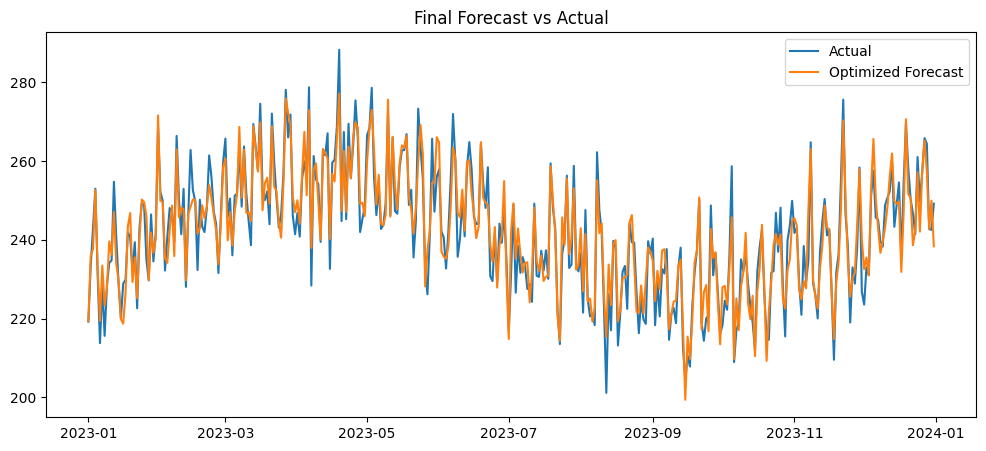

In [18]:
# Plot Final Forecast
plt.figure(figsize=(12,5))
plt.plot(test["ds"], test["y"], label="Actual")
plt.plot(test["ds"], opt_forecast["yhat"], label="Optimized Forecast")
plt.legend()
plt.title("Final Forecast vs Actual")
plt.show()

In [19]:
# Cross Validation
df_cv = cross_validation(opt_model, initial="1095 days", period="180 days", horizon="365 days")
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2021-01-05 00:00:00 and 2021-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,29.562909,5.437178,4.380545,0.022320,0.018759,0.022259,0.773700
1,38 days,29.116314,5.395953,4.326502,0.021968,0.017554,0.021914,0.776758
2,39 days,28.842981,5.370566,4.289237,0.021685,0.017554,0.021645,0.776758
3,40 days,27.491270,5.243212,4.225735,0.021404,0.016822,0.021355,0.785933
4,41 days,26.858404,5.182509,4.191925,0.021243,0.017186,0.021181,0.779817
